In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sbn

In [23]:
test_path = 'cell_images/test/'
train_path = 'cell_images/train/'

test_uninfected_path = test_path + '/uninfected'
train_uninfected_path = train_path + '/uninfected'

test_infected_path = test_path + '/parasitized'
train_infected_path = train_path + '/parasitized'

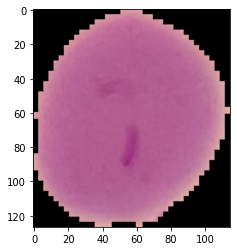

In [24]:
# Uninfected Sample

sample = train_uninfected_path + '/C13NThinF_IMG_20150614_131318_cell_179.png'
sample = imread(sample)
plt.imshow(sample)

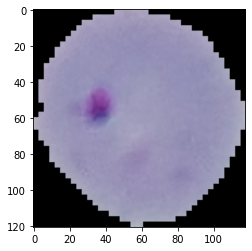

In [25]:
# Infected Sample

sample = train_infected_path + '/C189P150ThinF_IMG_20151203_142224_cell_84.png'
sample = imread(sample)
plt.imshow(sample)

# Finding Apt Resize Dimensions

In [30]:
width = list()
height = list()
channels = list()

for file_name in os.listdir(train_uninfected_path):
    
    if file_name.endswith('png'):
        
        img = imread(train_uninfected_path + f'/{file_name}')
        w, h, c = img.shape
    
        width.append(w)
        height.append(h)

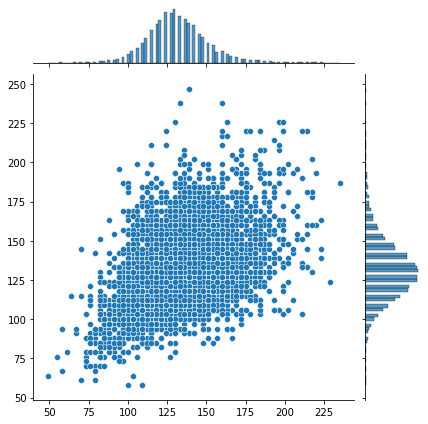

In [33]:
sbn.jointplot(x=width, y=height)

In [36]:
np.mean(width)

131.64820899110507

In [37]:
np.mean(height)

131.4041990544114

In [38]:
# Thus, every image will be resized to (130, 130, 3)

image_shape = (130, 130, 3)

# Using ImageDataGenerator

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [40]:
image_gen = ImageDataGenerator(
                rotation_range=20, # Rotate images randomly by 20 degrees
                width_shift_range=0.1, # Shift width of the image by 10%
                height_shift_range=0.1,
                rescale=1/255, # Normalize images
                shear_range=0.1, # Cutting away 10% of the image
                zoom_range=0.1, # Zoom in 10%
                horizontal_flip=True,
                fill_mode='nearest' # Read documentation
            )

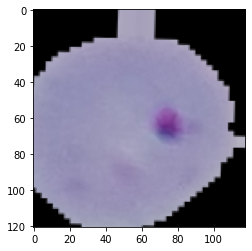

In [41]:
plt.imshow(image_gen.random_transform(sample))
# Perform transformations randomly that were defined above

In [42]:
image_gen.flow_from_directory(train_path)
# Refer course notebook to understand how to arrange data in folders 

Found 24958 images belonging to 2 classes.


In [43]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating the Model

* Refer to the course notebook for model history and results after each epoch

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

model = Sequential()

model.add(Conv2D(
    filters=32, 
    kernel_size=(3, 3),
    input_shape=image_shape,
    activation='relu',
))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(
    filters=64, 
    kernel_size=(3, 3),
    input_shape=image_shape,
    activation='relu',
))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(
    filters=64, 
    kernel_size=(3, 3),
    input_shape=image_shape,
    activation='relu',
))
model.add(MaxPool2D(2, 2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [47]:
batch_size = 16

In [48]:
train_image_gen = image_gen.flow_from_directory(
                        train_path, 
                        target_size=image_shape [:2],
                        color_mode='rgb',
                        class_mode='binary',
                    )

Found 24958 images belonging to 2 classes.


In [49]:
test_image_gen = image_gen.flow_from_directory(
                    test_path, 
                    target_size=image_shape [:2],
                    color_mode='rgb',
                    class_mode='binary',
                    shuffle=False, # Do not shuffle test data
                )

Found 2600 images belonging to 2 classes.


In [50]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [52]:
'''
results = model.fit_generator(
            train_image_gen,
            epochs=20,
            validation_data=test_image_gen,
            callbacks=[early_stop],
        )
'''

# To save time, using preloaded model

from tensorflow.keras.models import load_model

model = load_model('malaria_detector.h5')

# Evaluating Model Performance

In [55]:
model.metrics_names

['loss', 'accuracy']

In [54]:
model.evaluate(test_image_gen)

82/82 [==============================] - 21s 253ms/step - loss: 0.1408 - accuracy: 0.9535


[0.1408175826072693, 0.9534615278244019]

In [62]:
predictions = model.predict(test_image_gen)

predictions = predictions > 0.5 # The most important line, this decides tradeoff between
# true and false positives

predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [60]:
from sklearn.metrics import classification_report, confusion_matrix

In [61]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1300
           1       0.94      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



# Better way to work with Images

In [63]:
from tensorflow.keras.preprocessing import image

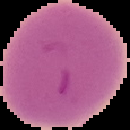

In [68]:
sample = train_uninfected_path + '/C13NThinF_IMG_20150614_131318_cell_179.png'

img = image.load_img(sample, target_size=image_shape)
img

In [72]:
img_as_array = image.img_to_array(img)
img_as_array.shape

(130, 130, 3)

# Making Model Predict Values on Unseen Data

In [73]:
img_as_array = img_as_array.reshape(1, 130, 130, 3)

In [74]:
model.predict(img_as_array)

array([[0.]], dtype=float32)

In [75]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}